# 8-Bit Autonomous Driving

In [972]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

![Sample](./images/driving_sample.gif)

## Review Training Data

Read in the training.csv data.  This is the data collected running the `01_training.py` file.


Column 0 = target value

In [973]:
from driver_util import show_road, get_training_data, direction
road_matrix, df = get_training_data("training.csv")
df.head()


,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,1,2,2,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0


Review different samples, the road configuration at that row and the target value

[[0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0]]


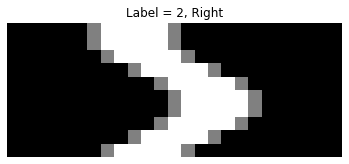

In [974]:
# 0 - offroad
# 1 - shoulder
# 2 - road
row = 33
show_road(road_matrix[row][1:], "Label = {}, {}".format(road_matrix[row][0], direction[road_matrix[row][0]]))

## Train a Machine Learning Model

Train a machine learning model on all 250 features to get a baseline accuracy before we reduce dimensions.

We will only use a LogisticRegression algorithm, however the `02_model_training.py` checks a number of models

In [975]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier


Create X, y variables

In [976]:
X = df.loc[:, 1:]
y = df.loc[:, 0]


In [977]:
X.shape

(150, 250)

In [978]:
y.shape

(150,)

Use cross_val_score to measure performance of model.  Note that the `02_model_training.py` script uses GridSearchCV to find the best parameters.

In [979]:
model = KNeighborsClassifier(n_neighbors=2, weights='distance')

In [980]:
cv_scores = cross_val_score(model, X, y, cv=5)
print(cv_scores, cv_scores.mean())


[0.83333333 0.9        0.86666667 0.9        0.86666667] 0.8733333333333334


# Reduce Dimensions with an AutoEncoder

In [981]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


We need to decide on what the final dimension or number of columns we would like to reduce the dataset to.  

This is somewhat arbitrary and we should try a number of dimensions

In [982]:
min_dims = 8

In [983]:
input_size = X.shape[1]
layer_1 = 128
layer_2 = 64
layer_3 = min_dims



In [984]:
# Create Encoder
encoder = Sequential()
encoder.add(Dense(layer_1, input_shape=(input_size,), activation="relu"))
encoder.add(Dense(layer_2,activation="relu"))
encoder.add(Dense(layer_3,activation="relu"))



In [985]:
# Create Decoder
decoder = Sequential()
decoder.add(Dense(layer_2, input_shape=(layer_3,), activation="relu"))
decoder.add(Dense(layer_1, activation="relu"))
decoder.add(Dense(input_size, activation="relu"))


In [986]:
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss="mse", optimizer=SGD(learning_rate=0.1))


Because we are not performing a traditional train/test split we are going to use all of the data to train the autoencoder.

In [987]:
encoder_scaler = MinMaxScaler()
X_scaled = encoder_scaler.fit_transform(X)

In [988]:
autoencoder.fit(X_scaled, X_scaled, epochs=500)


Epoch 1/500
5/5 [==============================] - 0s 2ms/step - loss: 0.2074
Epoch 2/500
5/5 [==============================] - 0s 2ms/step - loss: 0.2047
Epoch 3/500
5/5 [==============================] - 0s 2ms/step - loss: 0.2017
Epoch 4/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1987
Epoch 5/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1955
Epoch 6/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1924
Epoch 7/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1892
Epoch 8/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1860
Epoch 9/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1828
Epoch 10/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1797
Epoch 11/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1768
Epoch 12/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1741
Epoch 13/500
5/5 [==============================] - 0s 2ms/st

5/5 [==============================] - 0s 1ms/step - loss: 0.1227
Epoch 105/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1222
Epoch 106/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1216
Epoch 107/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1207
Epoch 108/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1198
Epoch 109/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1189
Epoch 110/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1181
Epoch 111/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1175
Epoch 112/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1169
Epoch 113/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1164
Epoch 114/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1159
Epoch 115/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1154
Epoch 116/500
5/5 [==============================] - 0

5/5 [==============================] - 0s 2ms/step - loss: 0.0870
Epoch 207/500
5/5 [==============================] - 0s 1ms/step - loss: 0.0869
Epoch 208/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0868
Epoch 209/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0867
Epoch 210/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0866
Epoch 211/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0865
Epoch 212/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0864
Epoch 213/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0863
Epoch 214/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0862
Epoch 215/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0861
Epoch 216/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0861
Epoch 217/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0860
Epoch 218/500
5/5 [==============================] - 0

5/5 [==============================] - 0s 2ms/step - loss: 0.0726
Epoch 309/500
5/5 [==============================] - 0s 1ms/step - loss: 0.0724
Epoch 310/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0722
Epoch 311/500
5/5 [==============================] - 0s 1ms/step - loss: 0.0721
Epoch 312/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0719
Epoch 313/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0716
Epoch 314/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0714
Epoch 315/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0713
Epoch 316/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0712
Epoch 317/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0711
Epoch 318/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0710
Epoch 319/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0710
Epoch 320/500
5/5 [==============================] - 0

5/5 [==============================] - 0s 1ms/step - loss: 0.0676
Epoch 411/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0675
Epoch 412/500
5/5 [==============================] - 0s 1ms/step - loss: 0.0675
Epoch 413/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0675
Epoch 414/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0674
Epoch 415/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0674
Epoch 416/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0674
Epoch 417/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0673
Epoch 418/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0673
Epoch 419/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0673
Epoch 420/500
5/5 [==============================] - 0s 1ms/step - loss: 0.0672
Epoch 421/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0672
Epoch 422/500
5/5 [==============================] - 0

<AxesSubplot:>

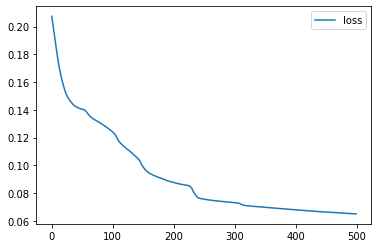

In [989]:
pd.DataFrame(autoencoder.history.history).plot()

Just use the encoder to reduce the dimensionality of the original dataset

In [990]:
X_scaled.shape

(150, 250)

In [991]:
# use encoder to compress or remove dimensionality
X_dim_reduced = encoder.predict(X_scaled)


In [992]:
X_dim_reduced.shape

(150, 8)

In [993]:
df_reduced = pd.DataFrame(X_dim_reduced)
df_reduced.head()

,0,1,2,3,4,5,6,7
0,3.839532,1.573181,5.299636,3.215772,3.506261,3.688581,2.828274,0.0
1,2.924082,1.255467,6.668110,1.621427,2.491302,3.982269,3.199170,0.0
2,1.280583,1.119774,7.947864,0.439529,1.672922,3.941223,4.485228,0.0
3,0.463251,1.773258,7.876879,1.446574,0.347986,2.632504,4.646770,0.0
4,0.124075,1.558314,7.167838,3.345156,0.096065,0.756637,4.887889,0.0


## Train a Machine Learning Model on new dataset

In [994]:
X_dim_reduced.shape

(150, 8)

In [995]:
y.shape

(150,)

In [996]:
model = KNeighborsClassifier(n_neighbors=2, weights='distance')
cv_scores = cross_val_score(model, X_dim_reduced, y, cv=5)
print(cv_scores, cv_scores.mean())




[0.8        0.9        0.86666667 0.9        0.86666667] 0.8666666666666668


In [998]:
results = [
    [1, 0.82],
    [2, 0.77],
    [4, 0.83],
    [8, 0.78],
    [16, 0.87],
    [32, 0.87],
    [64, 0.87],
    [128, 0.87],
    [1,0.75],
    [1,0.78],
    [1, 0.86],
    [4, 0.81],
    [4, 0.79],
    [4, 0.85],
    [16, 0.86],
    [16, 0.86],
    [8, 0.87]
    
]

In [999]:
df_results = pd.DataFrame(results, columns =['Dims', 'Accuracy'])

In [1000]:
df_results

,Dims,Accuracy
0,1,0.82
1,2,0.77
2,4,0.83
3,8,0.78
4,16,0.87
5,32,0.87
6,64,0.87
7,128,0.87
8,1,0.75
9,1,0.78


In [1002]:
print(df_results.groupby(['Dims'])[['Accuracy']].mean())

      Accuracy
Dims          
1     0.802500
2     0.770000
4     0.820000
8     0.825000
16    0.863333
32    0.870000
64    0.870000
128   0.870000
